In [1]:
import os, math, sys
from sys import stdout

import numpy as np
import matplotlib.pyplot as plt
import openmm.app  as omm_app
import openmm as omm
import simtk.unit as unit
from tqdm import tqdm
import os
import torch.nn as nn
import torch
# import openmmtools
from openmmtorch import TorchForce
from copy import deepcopy
import MDAnalysis as mda
from MDAnalysis.analysis import align, rms
from MDAnalysis.analysis.dihedrals import Dihedral

/export/ssule25/miniconda3/envs/ptorch/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/export/ssule25/miniconda3/envs/ptorch/lib/python3.11/site-packages/Bio/Application/__init__.py:40: BiopythonDeprecationWarning: The Bio.Application modules and modules relying on it have been deprecated.

Due to the on going maintenance burden of keeping command line application
wrappers up to date, we have decided to deprecate and eventually remove these
modules.

We instead now recommend building your command line and invoking it directly
with the subprocess module.
  warnings.warn(


In [2]:
import diffusion_map as dmap
import scipy as scipy

In [3]:
os.getcwd()

'/export/ssule25/CV_learning/butane/transition_rate'

In [8]:
# data_dir = np.load(f"butane_metad_carbon_apr7_fulldata.npz.npy", allow_pickle=True).item()
# data = data_dir['dataCV']
# indices = data_dir['tensor_indices']
# data = data[indices,:]
# Ms = data_dir['tensors']
# free_energy = data_dir['free_energy'][indices]
# kbT = data_dir['kbT']
# Ms = np.swapaxes(Ms,1,2)
# Ms = np.swapaxes(Ms,0,1)
# friction = 1.0 # should always be 1.0! 
# beta = friction/kbT
# target_measure = np.exp(-beta*free_energy)
# dihedrals = data_dir['dihedrals'][indices]
# data_dir = np.load(f"1D_CV_dnet.npz", allow_pickle=True)
data_dir = np.load(f"cossinCV_sep29.npz", allow_pickle=True)
# data_dir = np.load(f'../output/dihedral_TPT/dihedral_angle_CV/full_data.npz')
# data_dir = np.load(f'../output/traj_current/butane_metad_carbons_jul9.npz')
data = data_dir['data']
Ms = data_dir['diffusion_tensors']
kbT = data_dir['kbT']
# free_energy = data_dir['free_energy'].item()
# free_energy = free_energy['free energy values']
free_energy = data_dir['free_energy']
free_energy = free_energy - np.min(free_energy)

In [188]:
free_energy = np.load(f'../output/dihedral_TPT/cosdihedral_angle_CV/free_energy.npz')['free_energy']
Ms = np.load(f'../output/dihedral_TPT/cosdihedral_angle_CV/diffusion_tensors.npz')['diffusion_tensors']
data = np.load(f'../output/dihedral_TPT/cosdihedral_angle_CV/diffusion_tensors.npz')['evaluation_pts']

In [239]:
# roll 
using_dihedral_angle = False
if using_dihedral_angle:
    N = data.shape[0]
    data[data <= 0] = data[data <= 0] + 2*np.pi
    data = np.roll(data, N//2-1)
    Ms = np.roll(Ms, N//2-1)
    free_energy = np.roll(free_energy, N//2-1)

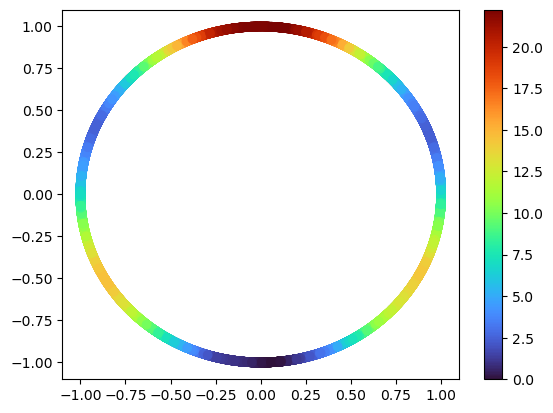

In [9]:
plt.scatter(data[:,0], data[:,1], \
            c=free_energy, \
            cmap = 'turbo')
plt.colorbar()

In [11]:
# data = data[:,np.newaxis]
# Ms = np.expand_dims(Ms, axis=1)
# Ms = np.expand_dims(Ms, axis=2)
free_energy = free_energy[:,np.newaxis]
free_energy = free_energy - np.min(free_energy)
beta = 1/kbT
target_measure = np.exp(-beta*free_energy)

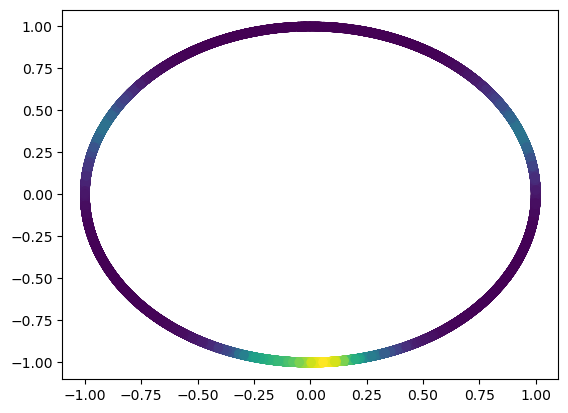

In [14]:
plt.scatter(data[:,0], data[:,1], c=target_measure)

# Visualize Free energy

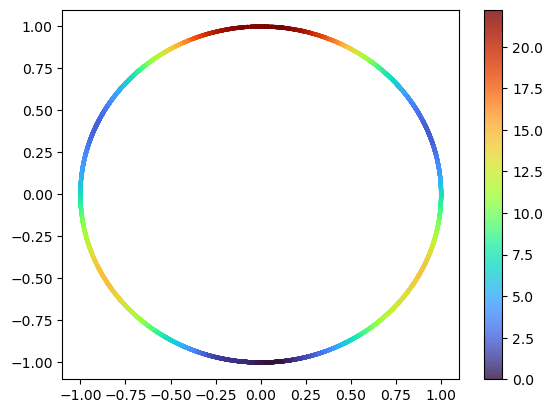

In [92]:
fig = plt.figure()
ax = plt.subplot()
c = ax.scatter(data[:,0], data[:,1], c = free_energy, alpha=0.8, s=4.0, cmap='turbo')
fig.colorbar(mappable=c)

# Visualize diffusion tensors! 

100%|████████████████████████████████████████| 122/122 [00:00<00:00, 643.13it/s]


(-1.2, 1.2)

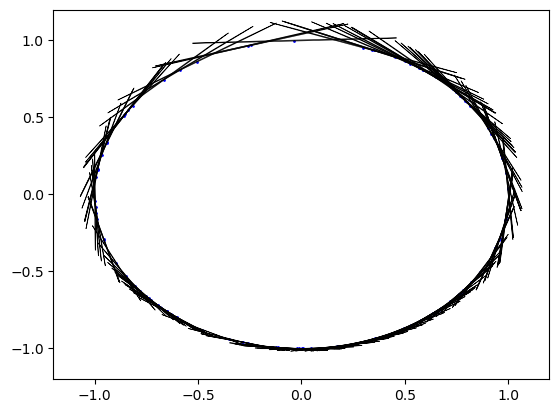

In [83]:
plot_scale = 1e-1
period = 100
N_samples = data.shape[0] // period 
for i in tqdm(range(N_samples)):
    # if final_angles[i] >= 2.5:
    # i = *i
    j = period*i
    cov = Ms[j,:,:]
    # cov = np.linalg.inv(cov)
    evals, evecs = np.linalg.eig(cov)
    idx = evals.argsort()[::-1]
    evals = evals[idx]
    evecs = evecs[:, idx]
    t = np.linspace(0, 2*np.pi)
    val = plot_scale*evecs*evals
    x = data[j,:]
    a = np.dot(val, np.vstack([np.cos(t), np.sin(t)]))
    plt.plot(a[0, :] + x[0], a[1, :] + x[1], linewidth=0.5, c='k')
    plt.scatter(x[0], x[1], color='b', s=1.0)

plt.xlim([-1.2,1.2])
plt.ylim([-1.2,1.2])

# Now start the diffusion map machine!

In [63]:
# eps = 10**(-1)
eps = 10**(-1)
pbc_dims = np.array([2*np.pi])
radius = None
n_neigh = 1500
density_mode = None
neigh_mode = "KNN"

# Compute target measure
method = "targetMMAP"
##### Compute some sort of diffusion map 
if method == 'MMAP' or method == 'targetMMAP':
    my_dmap = dmap.TargetMeasureMahalanobisDiffusionMap(epsilon=eps, diffusion_list=Ms,
                                                    radius=radius, n_neigh=n_neigh, neigh_mode=neigh_mode,
                                                    target_measure=target_measure, 
                                                    remove_isolated=True, 
                                                    pbc_dims=None)

In [64]:
# K = my_dmap._construct_kernel(data.T)
L = my_dmap.construct_generator(data.T)

Computing Mahalanobis distance matrix


100%|███████████████████████████████████| 12254/12254 [00:04<00:00, 2624.61it/s]


Computing KNN kernel
Number of nodes left after removing isolated: 12254
Ratio of nonzeros to zeros in kernel matrix: 0.1080264401861805


In [65]:
K = my_dmap.get_kernel()

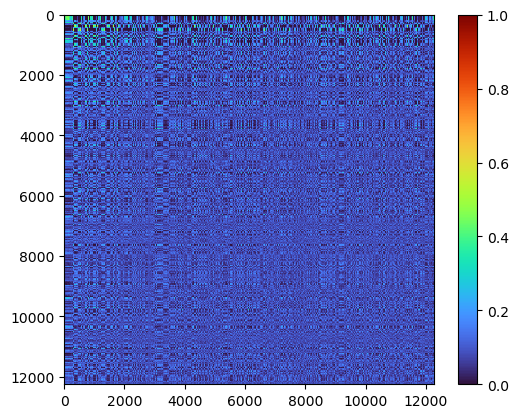

In [66]:
plt.imshow(K.toarray(), cmap='turbo')
plt.colorbar()

In [67]:
B_bool = np.logical_and(-1.0 <= data[:,1], data[:,1] <= np.cos(np.pi - 0.2))
A_bool = np.logical_and(np.cos(5*np.pi/3 - 0.1) <= data[:,1], \
                        data[:,1] <= np.cos(5*np.pi/3 + 0.1))
# A_bool = A_bool[:,0]
# B_bool = B_bool[:,0]
C_bool = np.logical_not(np.logical_or(A_bool, B_bool))

In [14]:
# compute the CV based A and B 
B_bool = np.logical_and(0.73 <= data, data <= 0.78)
A_bool = np.logical_and(1.05 <= data, data <= 1.08)
A_bool = A_bool[:,0]
B_bool = B_bool[:,0]
C_bool = np.logical_not(np.logical_or(A_bool, B_bool))

In [18]:
# compute the free energy based A and B
CV_sum = data[:,0] + data[:,1]
A_bool = np.logical_and(CV_sum >= 2.0, free_energy[:,0] <= 7.0)
B_bool = np.logical_and(CV_sum <= 2.0, free_energy[:,0] <= 10.0)
C_bool = np.logical_not(np.logical_or(A_bool,B_bool))

In [242]:
# dihedral based 
# dihedrals_ref = np.abs(data - np.pi)
# anti = dihedrals_ref < 0.2
# gauche = np.abs(dihedrals_ref - 2*np.pi/3) < 0.1
# C_bool = np.logical_not(np.logical_or(anti,gauche)).flatten()
# B_bool = gauche.flatten()
# A_bool = anti.flatten()

# anti = np.logical_and(data >= 0.0035, data <= 0.0065)
# gauche = np.logical_and(data >= 0.018, data <= 0.024)
# C_bool = np.logical_not(np.logical_or(anti,gauche)).flatten()
# B_bool = gauche.flatten()
# A_bool = anti.flatten()

anti = data <= -0.9
gauche = np.logical_and(data >= 0.35, data <= 0.45)
C_bool = np.logical_not(np.logical_or(anti,gauche)).flatten()
B_bool = gauche.flatten()
A_bool = anti.flatten()

In [68]:
q = my_dmap.construct_committor(B_bool,C_bool)

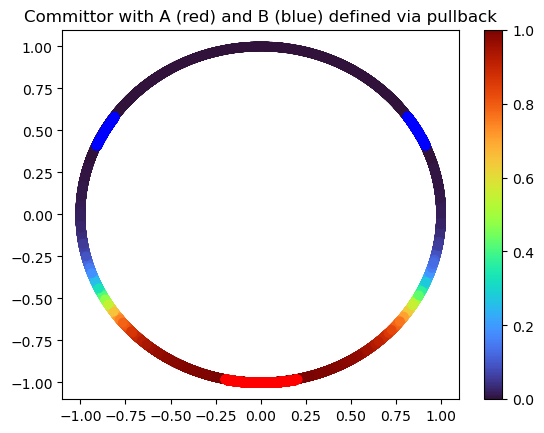

In [78]:
fig = plt.figure()
ax = fig.add_subplot()
c = ax.scatter(data[:,0], data[:,1], c=q[0], cmap='turbo')
ax.scatter(data[A_bool,0], data[A_bool,1], c='b')
ax.scatter(data[B_bool,0], data[B_bool,1], c='r')
ax.set_title("Committor with A (red) and B (blue) defined via pullback")
fig.colorbar(mappable=c)

In [70]:
committor = q[0]

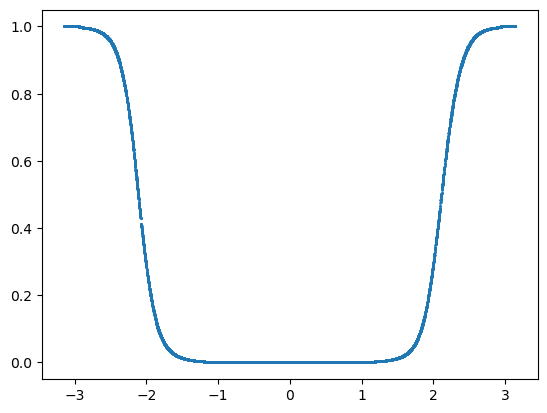

In [80]:
angles = np.arctan2(data[:,0], data[:,1])
plt.scatter(angles,committor,s=1.0)

# Compute rate!

In [170]:
kde = _compute_kde(my_dmap, data.T, 1)

In [73]:
# # TMD map w/ diffusion matrix
kde = np.sqrt(eps)*my_dmap._compute_kde(data.T) # correct for KDE 
target_measure = target_measure.flatten()
Z_dmap = np.mean(target_measure/kde)
weight_Zdmap = (1/Z_dmap)*(target_measure/kde)
Q = committor[np.newaxis, ...] - committor[:, np.newaxis, ...]

In [74]:
# rate = (1/beta)*(1/np.count_nonzero(C_bool))*np.sum(weight_Zdmap[C_bool]*my_dmap.L[C_bool, :].dot(committor**2))
# rate = (1/beta)*(1/np.count_nonzero(C_bool))*np.sum(weight_Zdmap[C_bool, np.newaxis]*(my_dmap.L)*(Q**2))
Ltimesqsqr = np.diag(my_dmap.L@(Q**2))
integral = weight_Zdmap[C_bool]@Ltimesqsqr[C_bool].T
rate = integral/(beta*np.count_nonzero(C_bool))

In [75]:
rate

0.011524504019456438

In [249]:
Z_dmap

0.07945127066602128